Trained with 1000 epochs while the loss is still 1500, ChatGpt said the eopch around 100 is enough.
There are some other issues, maybe the optimization method? Need to adjust later.

2025-4-15

A very interested thing: mac air m3 is much faster than google colab! 

for each eopch:
m3: 75ms, 0.75s
google colab: 15-20s, more than 20 times slower than m3

In [1]:
import pandas as pd
import numpy as np
import glob
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, RepeatVector, TimeDistributed, Masking
from tensorflow.keras.preprocessing.sequence import pad_sequences

#tf.config.run_functions_eagerly(True)  # Enable eager execution

In [2]:
import pandas as pd
import numpy as np

df = pd.read_csv('x.csv')
x = df.values

df1 = pd.read_csv('y.csv')
y = df1.values

x1 = np.delete(x, 0, axis = 1)
## X has 12 series, 12 tests, each series has 43664 data of temperature, 3 means initial speed, initial pressure and braking time.
X  = x1.reshape(12, 43664, 3)
x2 = X[:,::150,:]

y1 = np.delete(y, 0, axis = 1)
Y  = y1.reshape(12, 43664, 1)
y2 = Y[:,::150,:]

print(f'x shape is{x2.shape}')
print(f'y shape is{y2.shape}')

x shape is(12, 292, 3)
y shape is(12, 292, 1)


# Training

In [12]:
# Define the model
max_seq_length = 292
model = Sequential([
    Input(shape=(max_seq_length, 3)),  # ✅ Define input explicitly
    Masking(mask_value=0.0),  # No need for input_shape here
    LSTM(64, return_sequences=True),
    LSTM(32, return_sequences=True),
    TimeDistributed(Dense(1))  # Output sequence shape (batch, time_steps, 1)
])

# Compile the model
from keras.optimizers import Adam
model.compile(optimizer=Adam(learning_rate=1e-4), loss='mse')

# Compile the model
#model.compile(optimizer='adam', loss='mse')

# Print model summary
model.summary()

# Train the model
model.fit(x2, y2, epochs=100, batch_size=8, validation_split=0.2)
model.save("brake_temp_lstm.h5")


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking_2 (Masking)             │ (None, 292, 3)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 292, 64)        │        17,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 292, 32)        │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 292, 1)         │            33 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,857 (116.63 KB)

 Trainable params: 29,857 (116.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 870ms/step - loss: 24861.7109 - val_loss: 39232.2773
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 24167.2461 - val_loss: 39220.2812
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 25425.7988 - val_loss: 39208.5117
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 25729.6895 - val_loss: 39197.2812
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 21975.0742 - val_loss: 39186.2617
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 24825.2227 - val_loss: 39174.8398
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 25396.2285 - val_loss: 39163.2422
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 25511.5840 - val_loss: 39151.7305
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 24116.9844 - val_loss: 39139.8750
Epoch 10/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 25740.2305 - val_loss: 39127.9648
Epoch 11/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 25748.2148 - val_lo

# Validate

In [13]:
from tensorflow.keras.models import load_model
import numpy as np

from keras.models import load_model
import keras.backend as K

# Define custom MSE function
def mse(y_true, y_pred):
    return K.mean(K.square(y_true - y_pred))

# Load model with custom objects
model = load_model("brake_temp_lstm.h5", custom_objects={"mse": mse})

#new_input = new_input.reshape((1, 1, 3))  # Reshape for LSTM
new_input = x2[2:3,:,:]
# Predict temperature sequence
predicted_temp_sequence = model.predict(new_input)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step


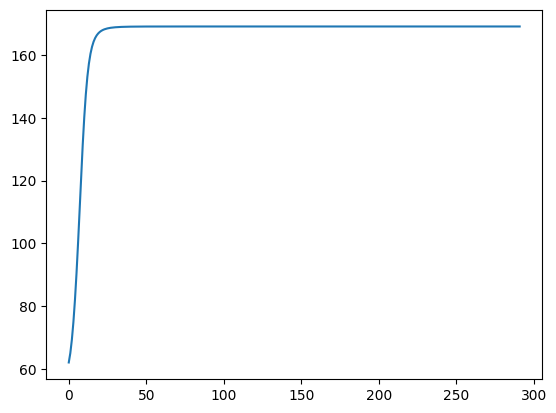

In [14]:
import matplotlib.pyplot as plt
plt.plot(predicted_temp_sequence[0][:]*20 + 60)